In [59]:
import cv2
import numpy as np
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# # Function to extract color features from an image
# def extract_color_features(image):
#     # Convert the image from BGR to RGB (OpenCV uses BGR by default)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Flatten the image into a 1D array of RGB values
#     pixels = image.reshape(-1, 3)
#     return pixels

In [61]:
zip_path = '/content/drive/MyDrive/E7-images.zip'

In [62]:
# Extract the zip folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

In [63]:
# List of image paths
image_paths = []
r = 1183
for i in range(1, r+1):
    if(i<10):
      image_paths.append(f'/content/images/000{i}.jpg')
    elif(i<100):
      image_paths.append(f'/content/images/00{i}.jpg')
    elif(i<1000):
      image_paths.append(f'/content/images/0{i}.jpg')
    else:
      image_paths.append(f'/content/images/{i}.jpg')

In [66]:
# Function to extract contour-related features from an image
def extract_contour_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

    # plt.imshow(binary, cmap='gray')
    # plt.title('Grayscale Image')
    # plt.axis('off')
    # plt.show()

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate contour features

    # image_with_contours = image.copy()
    # cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)
    # cv2_imshow(image_with_contours)

    contour_features = []
    for contour in contours:
        # Calculate contour area
        area = cv2.contourArea(contour)
        # Calculate contour perimeter
        perimeter = cv2.arcLength(contour, closed=True)

        epsilon = 0.01 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # num_corners = len(approx)
        num_edges = len(contour)
        # Append contour features
        contour_features.append([num_edges, area, perimeter])
    return contour_features

In [67]:
# Extract color features from each image
feature_vectors = []

# image = cv2.imread('/content/images/1083.jpg')
# cv2_imshow(image)
# features = extract_contour_features(image)

for path in image_paths:
    # Read the image
    image = cv2.imread(path)
    features = extract_contour_features(image)
    feature_vectors.append(features)

print(feature_vectors)

[[[74, 134729.5, 1565.4974738359451]], [[334, 130779.5, 1508.1736608743668]], [[506, 107648.5, 1403.7615364789963]], [[401, 100999.5, 1459.452878832817]], [[109, 146799.5, 1550.9533175230026]], [[352, 131862.0, 1554.558436870575]], [[242, 136897.5, 1572.315795660019]], [[391, 105226.5, 1469.9137754440308]], [[558, 112773.0, 1348.0285626649857]], [[241, 128220.0, 1535.7056245803833]], [[188, 140526.5, 1524.007140159607]], [[217, 135455.5, 1484.1736624240875]], [[256, 125420.0, 1511.847759962082]], [[221, 137219.5, 1516.1492756605148]], [[179, 89754.5, 1532.8355666399002]], [[383, 115368.0, 1510.7005722522736]], [[490, 108930.5, 1554.531087398529]], [[109, 146799.5, 1550.9533175230026]], [[427, 119750.5, 1473.2274836301804]], [[76, 123997.5, 1560.8111820220947]], [[658, 109086.0, 1344.513845205307]], [[675, 76818.0, 1379.1757488250732]], [[242, 137162.5, 1572.6589422225952]], [[364, 113319.0, 1487.3868639469147]], [[537, 103675.5, 1412.9574879407883]], [[491, 114901.5, 1438.482316851616]

**Removing Duplicates**

In [68]:
unique_images = set()
unique_image_paths = []

feature_vectors = np.array(feature_vectors)
features = feature_vectors.reshape(-1, 3)

for i in range(0, 1183):
  edge = features[i][0]
  area = features[i][1]
  peri = features[i][2]

  # print((edge, area, peri))

  if (edge, area, peri) not in unique_images:
        # Add the image properties to the set
        unique_images.add((edge, area, peri))
        # Add the image path to the array
        unique_image_paths.append(image_paths[i])

print(len(unique_image_paths))

173


In [69]:
unique_image_features = []
unique_images_list = unique_images.copy()

for i in range(len(unique_images)):
  image_features = list(unique_images_list.pop())
  unique_image_features.append(image_features)

print(np.shape(unique_image_features))

(173, 3)


**Tight-Fitting Box**

<ipython-input-70-bf4756048500>:34: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_points = cv2.boxPoints(min_box).astype(np.int0)


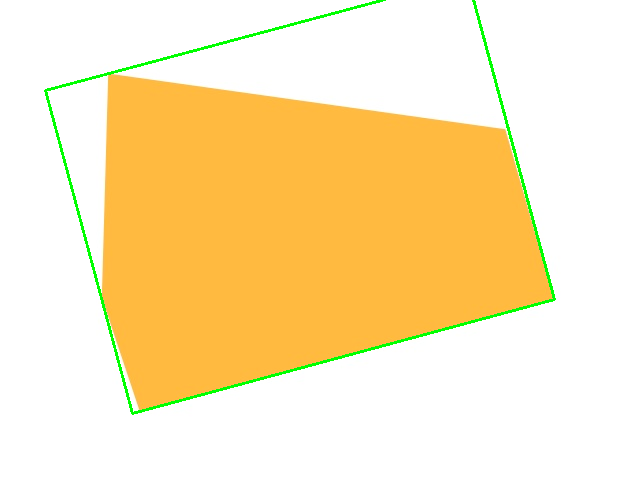

In [70]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Function to find tight-fitting bounding box and calculate its length and width
def calculate_tight_fitting_box(image):
    # Convert the image to grayscale

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour = max(contours, key=cv2.contourArea)

    # Find the oriented bounding box for the contour
    oriented_box = cv2.minAreaRect(contour)

    # Extract the length and width of the oriented bounding box
    length = max(oriented_box[1])
    width = min(oriented_box[1])

    return length, width, oriented_box

# Read an image
image = cv2.imread('/content/images/0171.jpg')

# Calculate the tight-fitting bounding box and its length, width, and coordinates
length, width, min_box = calculate_tight_fitting_box(image)

# Draw the tight-fitting bounding box on the image
image_with_box = image.copy()
box_points = cv2.boxPoints(min_box).astype(np.int0)
cv2.drawContours(image_with_box, [box_points], 0, (0, 255, 0), 2)

# Display the image with the tight-fitting bounding box
cv2_imshow(image_with_box)


In [71]:
# Extract color features from each image
tight_fit_features = []

for path in unique_image_paths:
    # Read the image
    image = cv2.imread(path)
    length, width, min_box = calculate_tight_fitting_box(image)
    tight_fit_features.append([length, width])

print(tight_fit_features)

[[450.0480651855469, 338.8497009277344], [452.0154113769531, 337.64990234375], [454.8719787597656, 321.92620849609375], [462.1556396484375, 319.0476989746094], [457.61279296875, 333.1894836425781], [441.7173767089844, 338.589599609375], [452.99993896484375, 337.99993896484375], [473.9609375, 310.20166015625], [456.08380126953125, 324.4205627441406], [441.0352783203125, 334.6479797363281], [453.0, 338.0], [449.0802917480469, 337.06353759765625], [436.1020202636719, 326.3282775878906], [449.62896728515625, 338.7528381347656], [459.94012451171875, 326.4166564941406], [451.0, 338.0], [452.0634460449219, 335.0518493652344], [447.6844482421875, 337.8164367675781], [453.0, 338.0], [454.22406005859375, 325.9875183105469], [452.0, 336.0], [453.0, 338.0], [438.5762939453125, 329.1494445800781], [446.5874938964844, 307.14630126953125], [464.5645751953125, 327.37579345703125], [450.5166931152344, 329.8821716308594], [453.0, 338.0], [453.0, 338.0], [479.1339416503906, 286.4784240722656], [453.0, 33

**Elbow Method**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

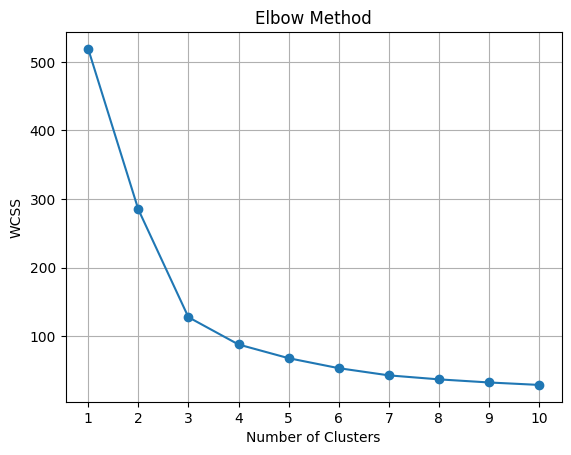

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = np.array(unique_image_features)
# X_new = np.concatenate((tight_fit_features, X), axis=1)

# Scale the feature vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [73]:
# Convert feature list to numpy array
X = np.array(unique_image_features)
# X = X.reshape(-1, 3)
# print(X.shape)
# X_new = np.concatenate((tight_fit_features, X), axis=1)
X_new = X
print(np.shape(X_new))

(173, 3)


**KMEANS**

In [74]:
# Scale the feature values
# X = X.reshape(-1, 2)
X = X_new

print(X.shape)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Define the number of clusters (low, medium, high complexity)
n_clusters = 3

# Build the KMeans clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Create a pipeline with scaling and clustering
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to the data
pipeline.fit(X)

# Get the cluster labels
cluster_labels = pipeline.predict(X)

# Print the cluster labels for each contour
for i, label in enumerate(cluster_labels):
    print(f"Contour {i+1}: Complexity cluster {label}")

(173, 3)
Contour 1: Complexity cluster 1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Contour 2: Complexity cluster 0
Contour 3: Complexity cluster 1
Contour 4: Complexity cluster 0
Contour 5: Complexity cluster 0
Contour 6: Complexity cluster 0
Contour 7: Complexity cluster 1
Contour 8: Complexity cluster 0
Contour 9: Complexity cluster 0
Contour 10: Complexity cluster 1
Contour 11: Complexity cluster 1
Contour 12: Complexity cluster 1
Contour 13: Complexity cluster 0
Contour 14: Complexity cluster 1
Contour 15: Complexity cluster 1
Contour 16: Complexity cluster 1
Contour 17: Complexity cluster 0
Contour 18: Complexity cluster 0
Contour 19: Complexity cluster 1
Contour 20: Complexity cluster 0
Contour 21: Complexity cluster 0
Contour 22: Complexity cluster 1
Contour 23: Complexity cluster 1
Contour 24: Complexity cluster 1
Contour 25: Complexity cluster 0
Contour 26: Complexity cluster 1
Contour 27: Complexity cluster 0
Contour 28: Complexity cluster 0
Contour 29: Complexity cluster 0
Contour 30: Complexity cluster 0
Contour 31: Complexity cluster 0
Contour 32: Compl

**HIERARCHICAL**

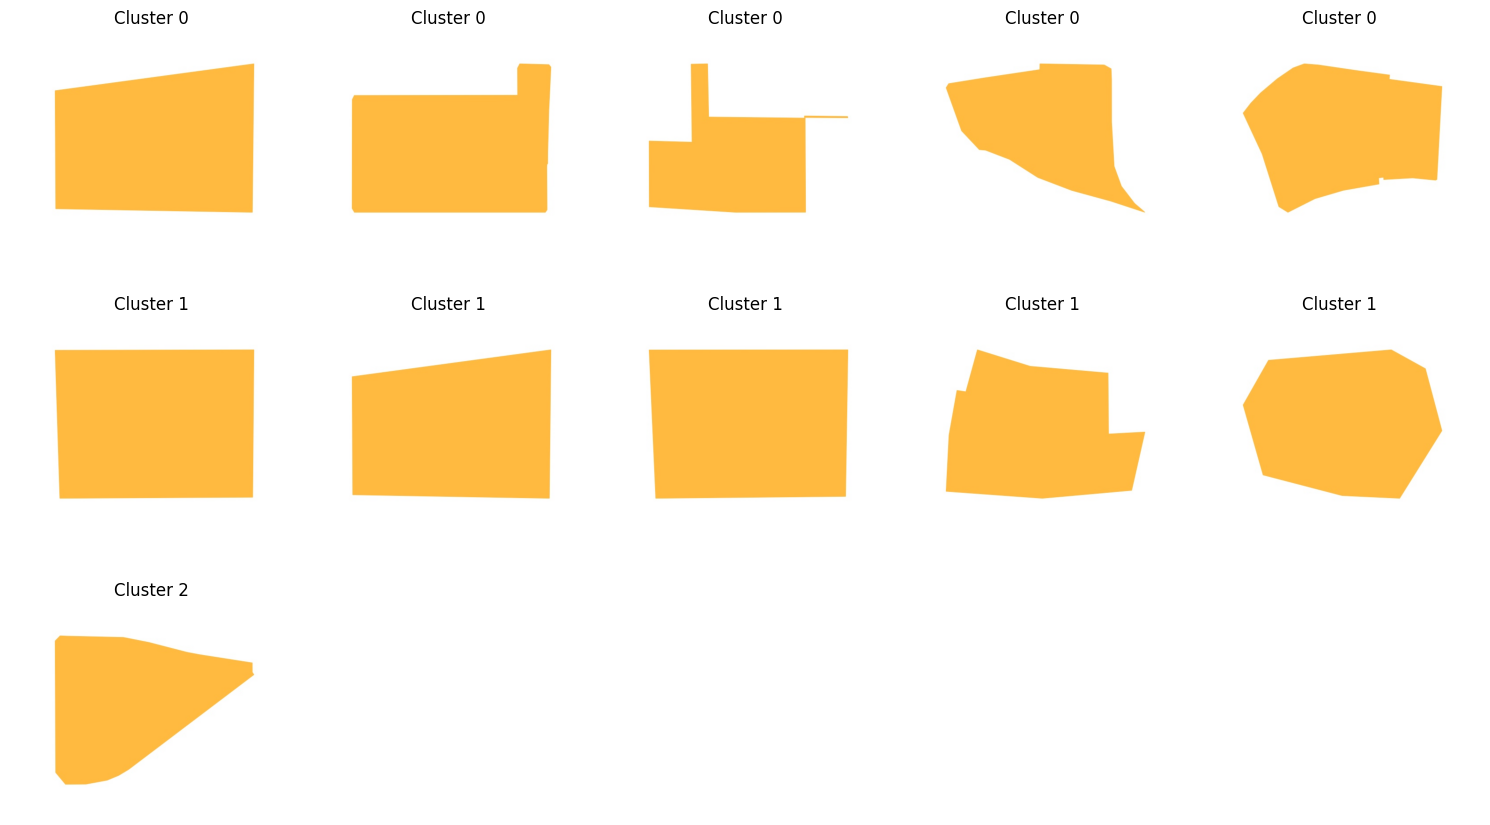

In [75]:
from sklearn.cluster import AgglomerativeClustering
import random
# Initialize the hierarchical clustering model
n_clusters = 3  # Number of clusters for low, medium, high complexity
clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Fit the model to the scaled data
clustering.fit(X_scaled)

# Get image paths for each cluster
cluster_image_paths = [[] for _ in range(n_clusters)]
for i, label in enumerate(clustering.labels_):
    cluster_image_paths[label].append(image_paths[i])

# Plot a few images from each cluster
num_images_per_cluster = 5
plt.figure(figsize=(15, 9))
for cluster_index, image_paths_cluster in enumerate(cluster_image_paths):
    random.shuffle(image_paths_cluster)  # Shuffle to get random images
    for i in range(min(num_images_per_cluster, len(image_paths_cluster))):
        image_path = image_paths_cluster[i]
        image = plt.imread(image_path)
        plt.subplot(n_clusters, num_images_per_cluster, cluster_index * num_images_per_cluster + i + 1)
        plt.imshow(image)
        plt.title(f'Cluster {cluster_index}')
        plt.axis('off')
plt.tight_layout()
plt.show()


In [76]:
# Function to display images
import matplotlib.pyplot as plt
def display_images(image_paths):
    plt.figure(figsize=(20, 8))
    for i, path in enumerate(image_paths, 1):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
print(cluster_labels)

[1 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1
 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1
 1 1 0 0 0 1 1 1 0 0 0 1 0 2 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0
 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1]


Cluster 1:


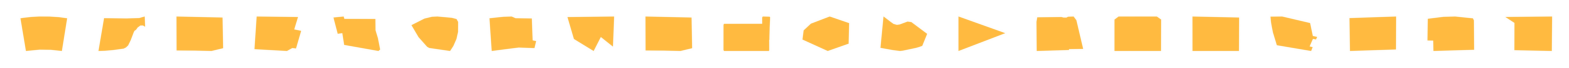

Cluster 2:


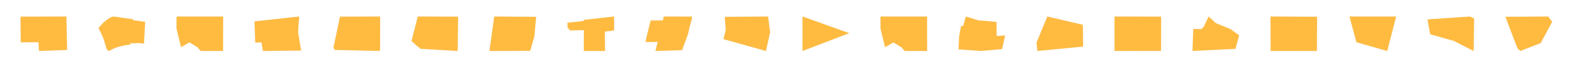

Cluster 3:
['/content/images/0088.jpg']


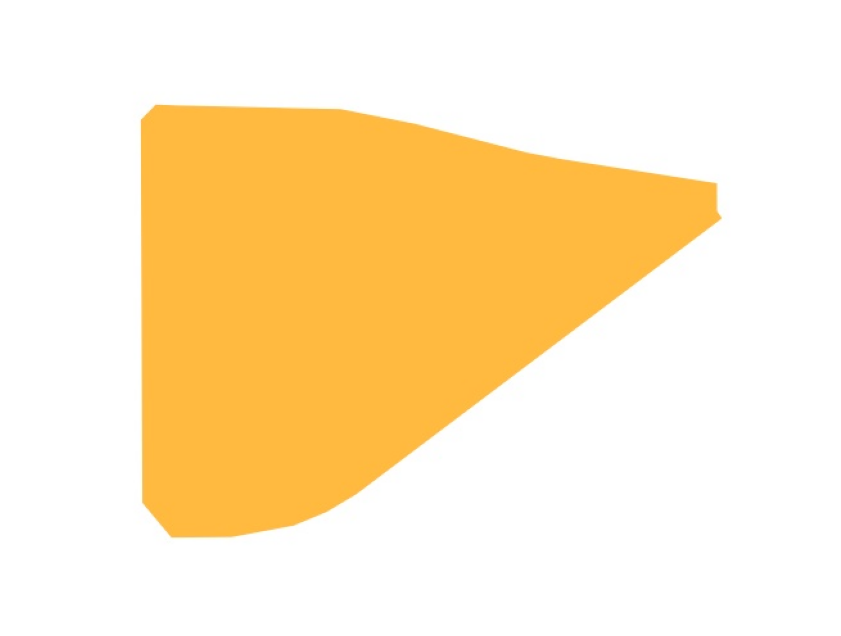

In [77]:
# Create lists to store image paths for each cluster
cluster_image_paths = [[] for _ in range(n_clusters)]
for i, label in enumerate(cluster_labels):
    if len(cluster_image_paths[label]) < 20:  # Limiting to 100 images per cluster
        cluster_image_paths[label].append(image_paths[i])

# Display images for each cluster
for cluster_index, image_paths_cluster in enumerate(cluster_image_paths):
    print(f"Cluster {cluster_index+1}:")
    if(cluster_index+1 == 3):
      print(image_paths_cluster)
    display_images(image_paths_cluster)


**VGG16**

In [78]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
# Function to extract features using a pre-trained CNN model (VGG16)
def extract_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    features = model.predict(x)
    return features

In [79]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

553467096/553467096 [==============================] - 7s 0us/step


In [80]:
# Extract features for all images
X_vgg = [extract_features(img_path) for img_path in unique_image_paths]

1/1 [==============================] - 1s 516ms/step


(173, 1, 4096)
(173, 4096)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


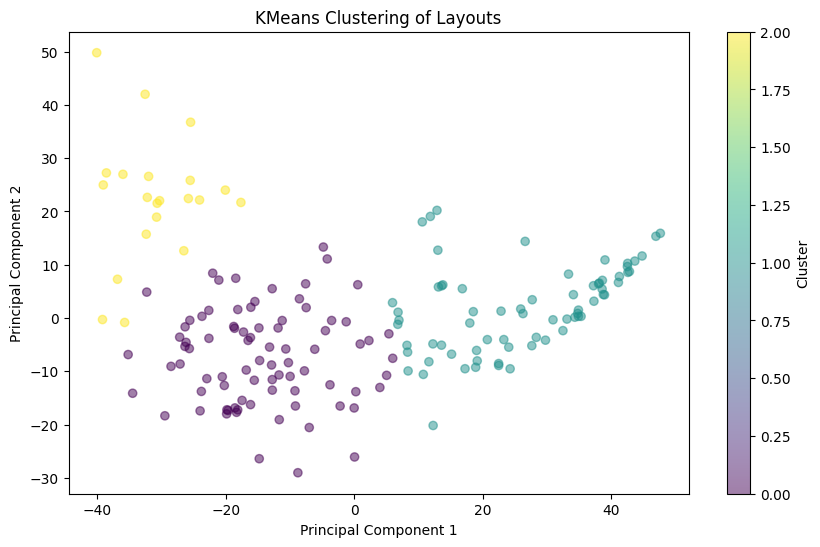

Cluster 0: Complexity 0.005163462366908789
Cluster 1: Complexity -0.03343946486711502
Cluster 2: Complexity 0.09130281209945679


In [82]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X contains the feature vectors
# X = np.array(feature_vectors)

print(np.shape(X_vgg))
X_vgg = np.array(X_vgg)
X_vgg = np.squeeze(X_vgg, axis=1)

print(np.shape(X_vgg))
# Scale the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vgg)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=4)  # You can adjust the number of components
X_pca = pca.fit_transform(X_scaled)

# Perform PCA for dimensionality reduction

# Perform KMeans clustering with 3 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

# Visualize the clustering result
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering of Layouts')
plt.colorbar(label='Cluster')
plt.show()

# Determine the complexity of each cluster (you may need to adjust this based on your features)
cluster_complexity = [np.mean(X_scaled[cluster_labels == i]) for i in range(n_clusters)]

# Print the complexity of each cluster
for i, complexity in enumerate(cluster_complexity):
    print(f"Cluster {i}: Complexity {complexity}")




In [83]:
# # X[0]
# np.shape(X)
# X_cpy = X.copy()

print(cluster_labels)

[1 0 2 2 1 0 1 0 2 0 0 0 0 1 0 0 0 0 1 2 0 1 0 2 0 0 1 1 2 1 1 0 1 2 1 0 1
 0 0 0 2 0 2 0 0 1 0 0 2 1 1 1 0 1 2 1 0 0 0 1 1 1 1 0 0 0 2 2 0 1 0 2 0 1
 1 1 1 2 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 2 0 0 0 0
 0 0 1 1 1 1 0 0 1 1 2 1 2 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0
 0 0 2 1 1 1 1 0 1 0 0 2 1 0 1 1 0 2 1 1 0 0 0 0 0]


In [85]:
# X_cpy = np.array(X_cpy)
# X_reshaped = X_cpy.reshape(X_cpy.shape[0], -1)
print(np.array(X_scaled).shape)

(173, 4096)


Cluster 0:


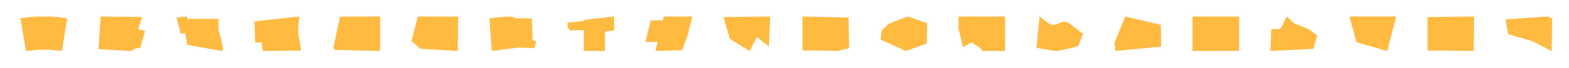

Cluster 1:


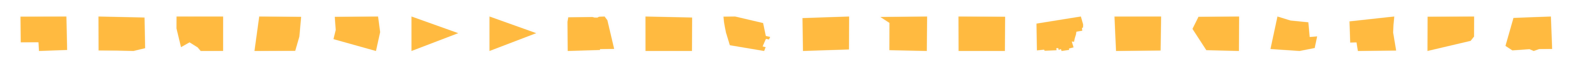

Cluster 2:


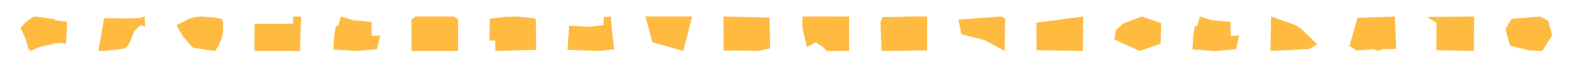

In [86]:
# Create lists to store image paths for each cluster
cluster_image_paths = [[] for _ in range(n_clusters)]
for i, label in enumerate(cluster_labels):
    if len(cluster_image_paths[label]) < 20:  # Limiting to 100 images per cluster
        cluster_image_paths[label].append(image_paths[i])

# Display images for each cluster
for cluster_index, image_paths_cluster in enumerate(cluster_image_paths):
    print(f"Cluster {cluster_index}:")
    display_images(image_paths_cluster)


In [87]:
features = np.array(unique_image_features)
# features = features.reshape(-1, 3)
print(np.shape(features))

(173, 3)


In [88]:
final_features = np.concatenate((features, tight_fit_features, cluster_labels[:, np.newaxis]), axis=1)
print(np.shape(final_features))
# print(image_paths)


(173, 6)


**Recommendation System**

In [89]:
from sklearn.neighbors import NearestNeighbors
X = final_features
y = unique_image_paths

# print(np.shape(X))
# X = np.squeeze(X, axis=1)

nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X)

input_edges = 738
input_area = 268
input_perimeter = 3100
input_length = 464
input_width = 324
input_cluster = 0

input_values = [[input_edges, input_area, input_perimeter, input_length, input_width, input_cluster]]

print(np.shape(input_values))

input_features = input_values  # Input features for which you want to find nearest neighbors
distances, indices = nbrs.kneighbors(input_features)

# Retrieve images corresponding to nearest neighbors
nearest_images = [unique_image_paths[idx] for idx in indices[0]]
print(nearest_images)

(1, 6)
['/content/images/0129.jpg', '/content/images/0126.jpg', '/content/images/0005.jpg', '/content/images/0396.jpg', '/content/images/0131.jpg']


/content/images/0129.jpg


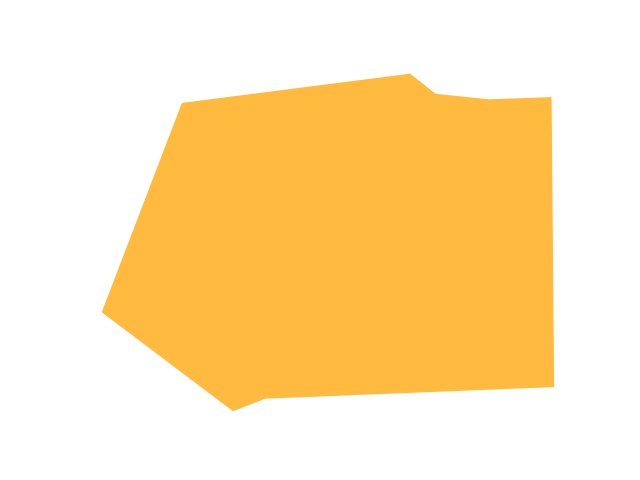

/content/images/0126.jpg


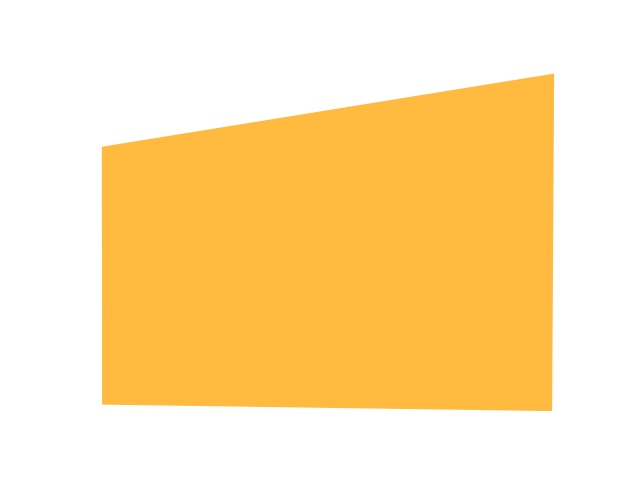

/content/images/0005.jpg


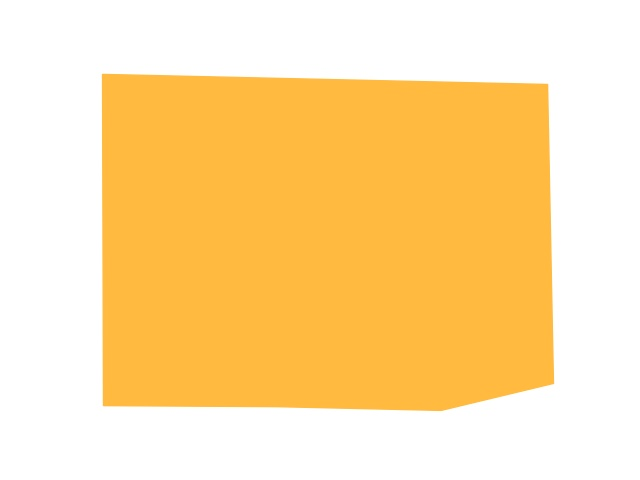

/content/images/0396.jpg


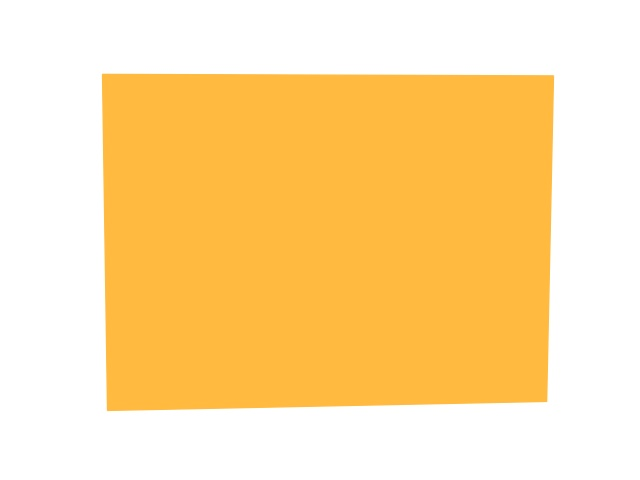

/content/images/0131.jpg


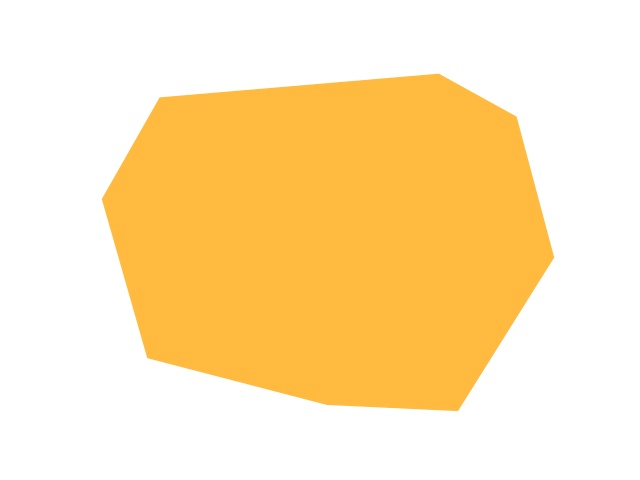

In [90]:
for image_index in nearest_images:
    # Load and display the image corresponding to the predicted index
    print(image_index)
    image_path = image_index
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [91]:
import pandas as pd

X_new = np.concatenate((features, tight_fit_features), axis=1)

# Convert features (X) to a pandas DataFrame
X_df = pd.DataFrame(X_new, columns=['edges', 'area', 'perimeter', 'length', 'width'])

# Convert cluster labels (y) to a pandas Series
y_series = pd.Series(cluster_labels, name='cluster_labels')

data = pd.concat([X_df, y_series], axis=1)

grouped = data.groupby('cluster_labels')

# Calculate the minimum and maximum values for each feature within each cluster
min_max_values = grouped.agg({'length': ['min', 'max'],
                              'width': ['min', 'max'],
                              'edges': ['min', 'max'],
                              'area': ['min', 'max'],
                              'perimeter': ['min', 'max']})

print(min_max_values)



                    length                   width             edges         \
                       min         max         min         max   min    max   
cluster_labels                                                                
0               389.318176  521.882385  284.529419  364.246368  20.0  738.0   
1               404.187805  459.368408  323.695099  356.608521  17.0  721.0   
2               386.389313  483.479767  286.478424  375.567169  31.0  583.0   

                   area              perimeter               
                    min       max          min          max  
cluster_labels                                               
0                 267.0  152275.5  1328.697599  3100.802293  
1               72171.0  152961.5  1301.508784  1621.259009  
2               84823.5  151266.5  1286.278347  1572.284271  


**Neural Network**

In [93]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

X = final_features

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

scale_factor_area = 2.0
scale_factor_cluster = 2.0
scale_factor_length = 2.0
scale_factor_width = 2.0

# # Multiply area and perimeter by the scale factors
# X[:, 1] *= scale_factor_area
# X[:, 3] *= scale_factor_length
# X[:, 4] *= scale_factor_width
# X[:, 5] *= scale_factor_cluster

y = unique_image_paths

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# print(y)


# Step 1: Split data into train and test sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import MultiLabelBinarizer

# Assuming y_train contains the recommended image paths for each sample
mlb = MultiLabelBinarizer()
y_list = [[label] for label in y]
y_encoded = mlb.fit_transform(y_list)


input_edges = 738
input_area = 100000
input_perimeter = 2000
input_length = 464
input_width = 324
input_cluster = 2

X_new_features = [[input_edges, input_area, input_perimeter, input_length, input_width, input_cluster]]

scaled_input_values = scaler.transform(X_new_features)

print(scaled_input_values)

# scaled_input_values[0][1] *= scale_factor_area
scaled_input_values[0][3] *= scale_factor_length
# scaled_input_values[0][4] *= scale_factor_width*10
scaled_input_values[0][5] *= scale_factor_cluster

print(scaled_input_values)


# Define the neural network architecture for recommendation
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(6,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(mlb.classes_), activation='sigmoid')  # Output layer with sigmoid activation for multi-label classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with input image features
model.fit(X, y_encoded, epochs=5)

# Make recommendations for new input features
predictions = model.predict(scaled_input_values)

print(predictions)


[[1.         0.65315385 0.39333824 0.57280188 0.43356279 1.        ]]
[[1.         0.65315385 0.39333824 1.14560377 0.43356279 2.        ]]
Epoch 1/5
6/6 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.0116
Epoch 2/5
6/6 [==============================] - 0s 3ms/step - loss: 0.6658 - accuracy: 0.0116
Epoch 3/5
6/6 [==============================] - 0s 3ms/step - loss: 0.6350 - accuracy: 0.0116
Epoch 4/5
6/6 [==============================] - 0s 3ms/step - loss: 0.5862 - accuracy: 0.0058
Epoch 5/5
1/1 [==============================] - 0s 56ms/step
[[0.2758336  0.14062195 0.28978252 0.3057385  0.3429744  0.28762475
  0.59214824 0.33114442 0.15045305 0.18864352 0.34344122 0.21710816
  0.29110152 0.48085847 0.34041148 0.16303079 0.30045736 0.16382945
  0.3850738  0.34782237 0.11438104 0.48309284 0.38224247 0.18539989
  0.2120384  0.2523896  0.15810506 0.28637403 0.19984756 0.2704589
  0.21316898 0.19204529 0.37436882 0.321889   0.20736644 0.29718316
  0.2976290

**Taken Best 5 values**

In [94]:
# Threshold for considering an image as recommended
threshold = 0.3

# Inverse transform the binary predictions
predicted_labels = (predictions > threshold).astype(int)
predicted_probabilities = predictions
predicted_images = mlb.inverse_transform(predicted_labels)

top_recommended_images = []
for sample_probabilities, sample_images in zip(predicted_probabilities, predicted_images):
    # Sort the images based on predicted probabilities
    sorted_images = [image for _, image in sorted(zip(sample_probabilities, sample_images), reverse=True)]
    # Select the top 5 images
    top_recommended_images.append(sorted_images[:5])


recommended_images = []
for i in range(0,len(top_recommended_images[0])):
  print(top_recommended_images[0][i])
  image =  label_encoder.inverse_transform([top_recommended_images[0][i]])
  recommended_images.append(image)


print(recommended_images)

recommended_images = np.array(recommended_images)
recommended_images = np.array(recommended_images).flatten()

14
107
164
48
33
[array(['/content/images/0015.jpg'], dtype='<U24'), array(['/content/images/0209.jpg'], dtype='<U24'), array(['/content/images/0763.jpg'], dtype='<U24'), array(['/content/images/0053.jpg'], dtype='<U24'), array(['/content/images/0036.jpg'], dtype='<U24')]


['/content/images/0015.jpg' '/content/images/0209.jpg'
 '/content/images/0763.jpg' '/content/images/0053.jpg'
 '/content/images/0036.jpg']
/content/images/0015.jpg


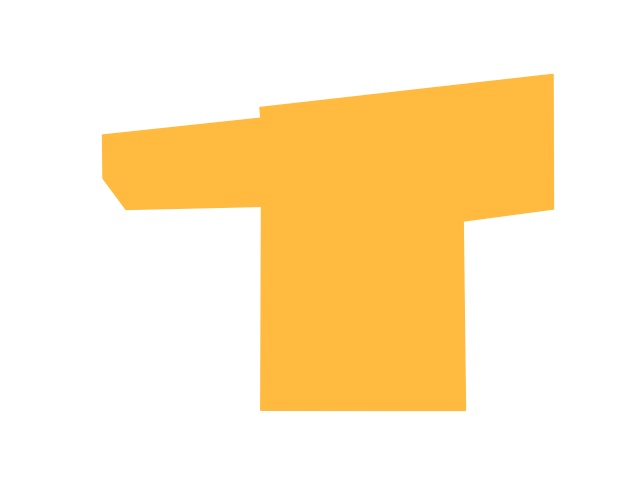

/content/images/0209.jpg


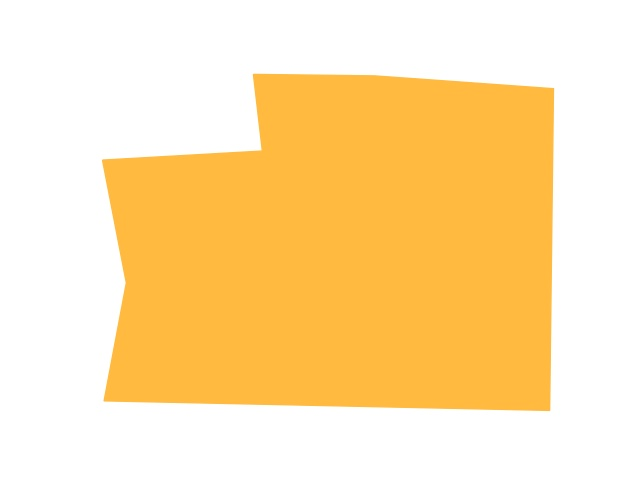

/content/images/0763.jpg


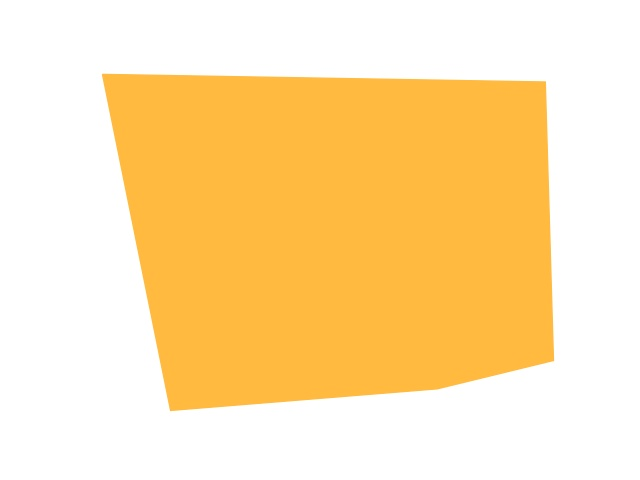

/content/images/0053.jpg


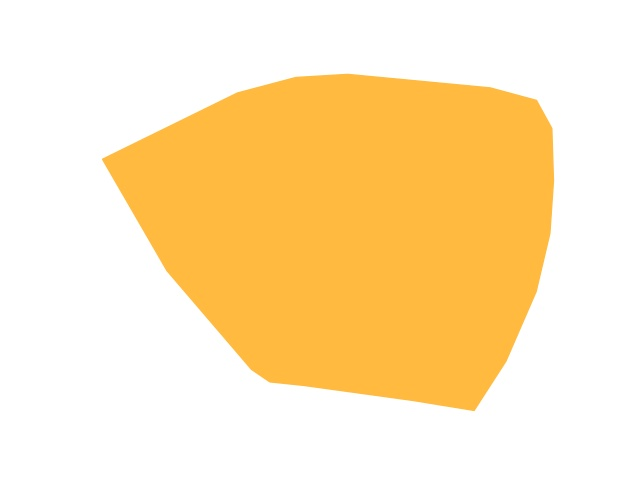

/content/images/0036.jpg


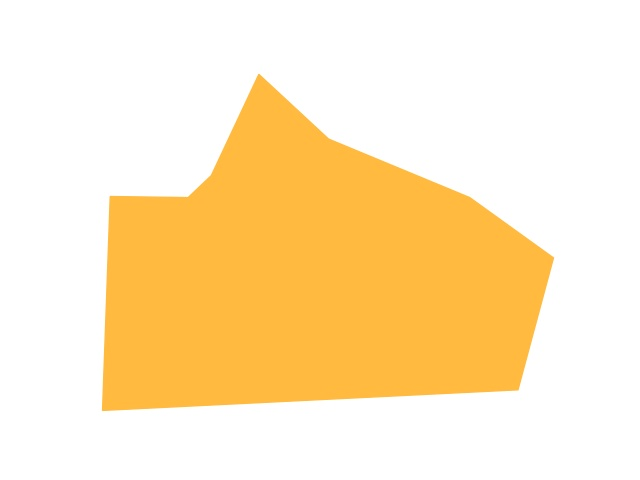

In [95]:

print(recommended_images)
for image_index in recommended_images:
    # Load and display the image corresponding to the predicted index
    # image_index = image_index[i]
    print(image_index)
    image_path = image_index
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [96]:
image = cv2.imread('/content/images/0050.jpg')
# 429 50
# ['/content/images/0129.jpg', '/content/images/0126.jpg', '/content/images/0005.jpg', '/content/images/0396.jpg', '/content/images/0131.jpg']

input_edges = 738
input_area = 100000
input_perimeter = 2000
input_length = 464
input_width = 324
input_cluster = 0

# Calculate the tight-fitting bounding box and its length, width, and coordinates
length, width, min_box = calculate_tight_fitting_box(image)
features = (extract_contour_features(image))

print('Number of Edges: ', features[0][0])
print('Area: ', features[0][1])
print('Perimeter: ', features[0][2])
print('Length: ', length)
print('Width: ', width)
cluster = pipeline.predict([[input_edges, input_area, input_perimeter]])
print('Cluster: ', cluster)
print(features, length, width)

print(cluster)

Number of Edges:  70
Area:  148460.0
Perimeter:  1566.0832602977753
Length:  453.0
Width:  338.0
Cluster:  [0]
[[70, 148460.0, 1566.0832602977753]] 453.0 338.0
[0]
